In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.style as style 
import seaborn as sns
style.use("tableau-colorblind10")




In [99]:
# Import and aggreagate evaluation results
df_12 = pd.read_csv(r"csv_files\avg_results_12.csv")
df_36 = pd.read_csv(r"csv_files\avg_results_36.csv")
df_60 = pd.read_csv(r"csv_files\avg_results_60.csv")
df_84 = pd.read_csv(r"csv_files\avg_results_84.csv")
df_96 = pd.read_csv(r"csv_files\avg_results_96.csv")
df_216 = pd.read_csv(r"csv_files\avg_results_216.csv")

df = pd.concat([df_12, df_36, df_60,df_84,df_96,df_216], ignore_index=True) #averages
df.rename(columns={'average_gini-index': 'average_gini_index'}, inplace=True)
df['algorithm'] = df['algorithm'].map(lambda x: 'OCCR' if x == 'Ranking' else x)
df['algorithm'] = df['algorithm'].map(lambda x: 'CPCK' if x == 'PCK' else x)

results_12 = pd.read_csv(r"csv_files\results_12.csv")
results_36 = pd.read_csv(r"csv_files\results_36.csv")
results_60 = pd.read_csv(r"csv_files\results_60.csv")
results_84 = pd.read_csv(r"csv_files\results_84.csv")
results_96 = pd.read_csv(r"csv_files\results_96.csv")
results_216 = pd.read_csv(r"csv_files\results_216.csv")
results = pd.concat([results_12,results_36,results_60,results_84,results_96,results_216], ignore_index=True) #all results
results['algorithm'] = results['algorithm'].map(lambda x: 'OCCR' if x == 'Ranking' else x)
results['algorithm'] = results['algorithm'].map(lambda x: 'CPCK' if x == 'PCK' else x)

# OCCR internal runtimes
occr_internal_times = pd.read_csv(r"csv_files\occr_internal_times.csv")

# Random comparison
results_84_no_ml = pd.read_csv(r"csv_files\no_ml_cl_avg_results_84.csv")
results_84_random = pd.read_csv(r"csv_files\avg_random_84.csv")

results_84_random_vs_algos = pd.concat([results_84_no_ml,results_84_random], ignore_index=True) #all results
results_84_random_vs_algos["algorithm"] = results_84_random_vs_algos["algorithm"].replace("Ranking", "OCCR")
results_84_random_vs_algos['algorithm'] = results_84_random_vs_algos['algorithm'].map(lambda x: 'CPCK' if x == 'PCK' else x)

# Define storage path (CHANGE TO YOUR DIRECTORY)
output_dir_comparison = r"C:\Users\Admin\Desktop\AGAT\agat\src\algorithms_comparison\comparison_plots"

In [100]:
# Mean pw distance for averages
def calculate_mean_pw(row):
    group_size = row['group_size']
    n_members = row['n_members']
    average_distance = row['average_distance']
    
    # Calculate the binomial coefficient (group_size choose 2)
    binom = (group_size * (group_size - 1)) / 2
    
    # Apply the formula
    result = average_distance / (binom * (n_members / group_size))
    return result
# Mean pw distance for individual results
def calculate_mean_pw_results(row):
    group_size = row['group_size']
    n_members = row['n_members']
    average_distance = row['distance']
    
    # Calculate the binomial coefficient (group_size choose 2)
    binom = (group_size * (group_size - 1)) / 2
    
    # Apply the formula
    result = average_distance / (binom * (n_members / group_size))
    return result

def calculate_mean_pw_inf(row):
    group_size = row['group_size']
    n_members = row['n_members']
    lower_bound_distance = row['lower_bound_distance']
    
    # Calculate the binomial coefficient (group_size choose 2)
    binom = (group_size * (group_size - 1)) / 2
    
    # Apply the formula
    result = lower_bound_distance / (binom * (n_members / group_size))
    return result
# Calculate mean for pairwise distance and lower bound
df['mean_pw_distance'] = df.apply(calculate_mean_pw, axis=1)
df['mean_lower_bound'] = df.apply(calculate_mean_pw_inf, axis=1)
results["mean_pw_distance"] = results.apply(calculate_mean_pw_results, axis=1)
results_84_random_vs_algos["average_distance"] = results_84_random_vs_algos.apply(calculate_mean_pw, axis=1)

In [135]:
# Time
# Filter the dataframe to get unique group sizes
group_sizes = df['group_size'].unique()

# Define colors
bar_colors = ['#ABABAB', '#5F9ED1', '#C85200']  # List of colors for the bars
markers = ["H", "P", "s"]


# Loop over each group size
for group_size in group_sizes:
    # Filter the DataFrame based on the current group size
    filtered_df = df[df['group_size'] == group_size]

    # Grouping by 'n_members' and 'algorithm'
    grouped = filtered_df.groupby(['n_members', 'algorithm']).agg(
        avg_distance=('mean_pw_distance', 'mean'),
        avg_time=('average_time', 'mean')
    ).reset_index()

    # List of unique algorithms and n_members
    algorithms = filtered_df['algorithm'].unique()
    n_members_list = filtered_df['n_members'].unique()

    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar width and positions for the bars
    bar_width = 0.25
    x = np.arange(len(n_members_list))

    # Plot the bar plots for distances
    for i, algo in enumerate(algorithms):
        distance_values = grouped[grouped['algorithm'] == algo]['avg_distance'].values
        ax1.bar(x + i * bar_width, distance_values, bar_width, label=f'{algo}', alpha=1.0, color=bar_colors[i % len(bar_colors)])

    # Creating a second y-axis for the time measurements
    ax2 = ax1.twinx()

    # Plot the line plots for times
    for i, algo in enumerate(algorithms):
        time_values = grouped[grouped['algorithm'] == algo]['avg_time'].values
        ax2.plot(x + i * bar_width, time_values, marker=markers[i % len(markers)],markersize=8, label=f'{algo}', linestyle='-', linewidth=1, color="black")

    # Set labels
    ax1.set_xlabel('Number of Members', fontsize=12)
    ax1.set_ylabel('Ø Pair-Wise Distance Within Each Group', fontsize=12)
    ax2.set_ylabel('Time (Seconds)', fontsize=12)

    # Set x-ticks for the number of members
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(n_members_list)

    

    # Title and legends
    plt.title(f'Comparison of Algorithms: Distance and Time (Group Size {group_size})', fontsize=14)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), title="Distance")
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85), title="Time")

    # Save the plot as PNG
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_comparison, f'time_{group_size}_comparison.png'))

    #plt.savefig(f'{output_dir_comparison}time_{group_size}_comparison.png')  # Save as PNG file
    plt.close()  # Close the figure to prevent memory issues

In [141]:
# Infimum
# Filter the dataframe to get unique group sizes
group_sizes = df['group_size'].unique()

# Define colors
bar_colors = ['#ABABAB', '#5F9ED1', '#C85200']  # List of colors for the bars

# Loop over each group size
for group_size in group_sizes:
    # Filter the DataFrame based on the current group size
    filtered_df = df[df['group_size'] == group_size]

    # Grouping by 'n_members' and 'algorithm'
    grouped = filtered_df.groupby(['n_members', 'algorithm']).agg(
        avg_distance=('mean_pw_distance', 'mean'),
        lower_bound_distance=('mean_lower_bound', 'first')  # Assuming lower bound is constant for each n_members
    ).reset_index()

    # List of unique algorithms and n_members
    algorithms = filtered_df['algorithm'].unique()
    n_members_list = filtered_df['n_members'].unique()

    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar width and positions for the bars
    bar_width = 0.25
    x = np.arange(len(n_members_list))

    # Plot the bar plots for distances
    for i, algo in enumerate(algorithms):
        distance_values = grouped[grouped['algorithm'] == algo]['avg_distance'].values
        bars = ax1.bar(x + i * bar_width, distance_values, bar_width, label=f'{algo}', alpha=1.0,color= bar_colors[i % len(bar_colors)])

        # Add the value at the top of each bar
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                     ha='center', va='bottom', fontsize=9, color='black')

    # Plot the lower bound distances as horizontal lines for each n_members on the left y-axis
    for i, n_members in enumerate(n_members_list):
        # Get the lower bound distance for this n_members (same for all algorithms)
        lower_bound = grouped[grouped['n_members'] == n_members]['lower_bound_distance'].iloc[0]
        
        # Define the x-coordinates for the horizontal line (covering the width of all bars)
        x_start = x[i] - bar_width / 2
        x_end = x[i] + len(algorithms) * bar_width - bar_width / 2

        # Create the lower bound line only for the first n_members value to avoid duplicate legend entries
        if i == 0:
            ax1.plot([x_start, x_end], [lower_bound, lower_bound], label='Lower Bound', color='black', linestyle='-', linewidth=2)
        else:
            ax1.plot([x_start, x_end], [lower_bound, lower_bound], color='black', linestyle='-', linewidth=2)


    # Set labels
    ax1.set_xlabel('Number of Members', fontsize=12)
    ax1.set_ylabel('Ø Pair-Wise Distance Within Each Group', fontsize=12)

    # Set x-ticks for the number of members
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(n_members_list)

    # Title and legends
    plt.title(f'Comparison of Algorithms: Distance and Lower Bound (Group Size {group_size})', fontsize=14)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Distance & Lower Bound")

    # Save the plot as PNG
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_comparison, f'lbound_{group_size}_comparison.png'))
    plt.close()  # Close the figure to prevent memory issues


In [155]:
import matplotlib.lines as mlines

# Gini
# Filter the dataframe to get unique group sizes
group_sizes = df['group_size'].unique()

# Define colors
bar_colors = ['#ABABAB', '#5F9ED1', '#C85200']  # List of colors for the bars

# Loop over each group size
for group_size in group_sizes:
    # Filter the DataFrame based on the current group size
    filtered_df = df[df['group_size'] == group_size]

    # Grouping by 'n_members' and 'algorithm'
    grouped = filtered_df.groupby(['n_members', 'algorithm']).agg(
        avg_distance=('mean_pw_distance', 'mean'),
        gini=('average_gini_index', 'first')  # Assuming gini is the same for each n_members
    ).reset_index()

    # List of unique algorithms and n_members
    algorithms = filtered_df['algorithm'].unique()
    n_members_list = filtered_df['n_members'].unique()

    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar width and positions for the bars
    bar_width = 0.25
    x = np.arange(len(n_members_list))

    # Plot the bar plots for distances
    for i, algo in enumerate(algorithms):
        distance_values = grouped[grouped['algorithm'] == algo]['avg_distance'].values
        bars = ax1.bar(x + i * bar_width, distance_values, bar_width, label=f'{algo}', alpha=1.0, color=bar_colors[i % len(bar_colors)])

        # Add the value at the top of each bar
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
                     ha='center', va='bottom', fontsize=9, color='black')

        # Plot the Gini index as a horizontal line for the current algorithm
        for j, n_members in enumerate(n_members_list):
            # Get the Gini index for this n_members and algorithm
            gini_value = grouped[(grouped['n_members'] == n_members) & (grouped['algorithm'] == algo)]['gini'].iloc[0]

            # Define the x-coordinates for the Gini line (match the width of the bars)
            x_center = x[j] + i * bar_width
            x_start = x_center - bar_width / 2  # Left edge of the bar
            x_end = x_center + bar_width / 2    # Right edge of the bar

            # Plot the Gini line for the current bar
            ax1.plot([x_start, x_end], [gini_value, gini_value], color='black', linestyle='-', linewidth=1.5)

    # Add a black line for the Gini-Index to the legend
    gini_line = mlines.Line2D([], [], color='black', label='Gini-Index', linestyle='-', linewidth=2)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Distance & Gini-Index", handles=[gini_line] + [*ax1.get_legend_handles_labels()[0]])

    # Set labels
    ax1.set_xlabel('Number of Members', fontsize=12)
    ax1.set_ylabel('Ø Pair-Wise Distance Within Each Group', fontsize=12)

    # Set x-ticks for the number of members
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(n_members_list)

    # Title and legends
    plt.title(f'Comparison of Algorithms: Distance and Gini-Index (Group Size {group_size})', fontsize=14)

    # Save the plot as PNG
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_comparison, f'gini_{group_size}_comparison.png'))
    plt.close()  # Close the figure to prevent memory issues




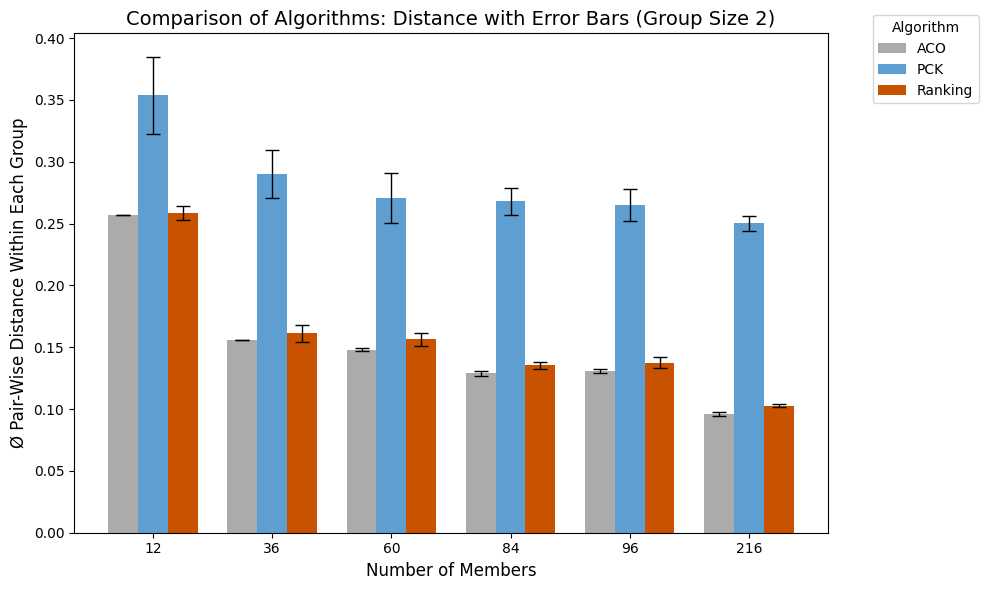

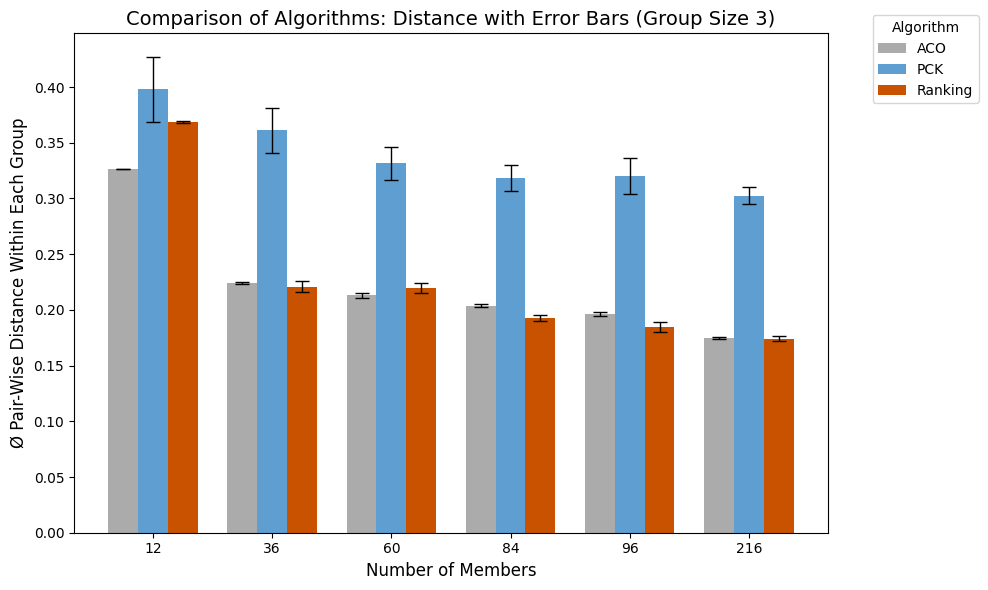

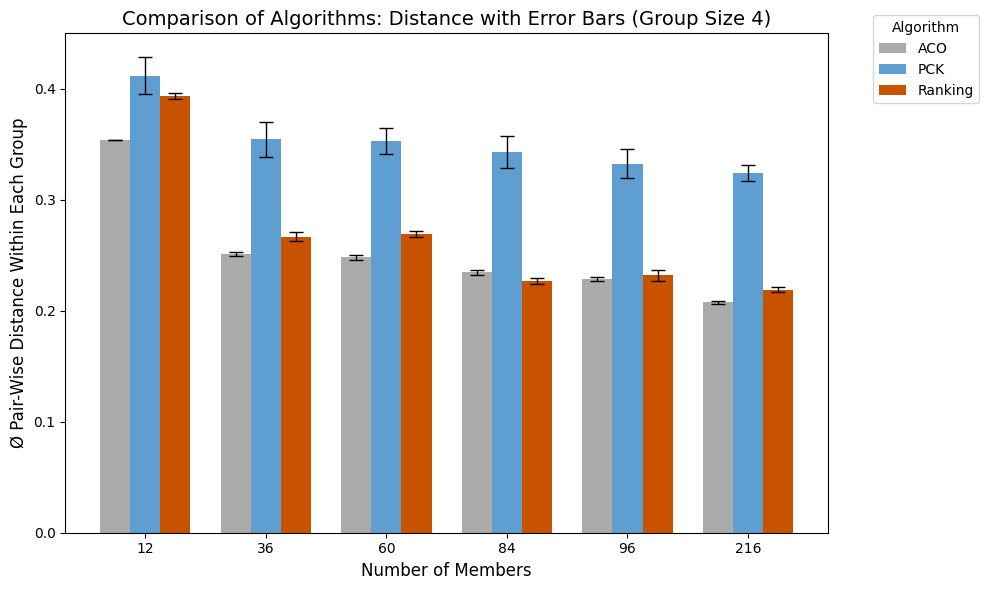

In [10]:
# Error bars
import numpy as np
import os
import matplotlib.pyplot as plt

# Unique group sizes
group_sizes = df['group_size'].unique()

# Define colors
bar_colors = ['#ABABAB', '#5F9ED1', '#C85200']  

# Loop over each group size
for group_size in group_sizes:
    # Filter the DataFrame based on the current group size
    filtered_df = df[df['group_size'] == group_size]
    filtered_results = results[results['group_size'] == group_size]  # Use actual results for error bars

    # Compute mean and standard deviation using results["mean_pw_distance"]
    grouped = filtered_results.groupby(['n_members', 'algorithm']).agg(
        avg_distance=('mean_pw_distance', 'mean'),
        std_distance=('mean_pw_distance', 'std')  # Standard deviation for error bars
    ).reset_index()

    # List of unique algorithms and n_members
    algorithms = filtered_df['algorithm'].unique()
    n_members_list = filtered_df['n_members'].unique()

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar width and positions
    bar_width = 0.25
    x = np.arange(len(n_members_list))

    # Plot bars
    for i, algo in enumerate(algorithms):
        algo_group = grouped[grouped['algorithm'] == algo]
        distance_values = algo_group['avg_distance'].values
        std_values = algo_group['std_distance'].values  # Standard deviation for error bars

        # Bar plot
        bars = ax1.bar(
            x + i * bar_width, 
            distance_values, 
            bar_width, 
            label=f'{algo}', 
            alpha=1.0, 
            color=bar_colors[i % len(bar_colors)]
        )

        # Add error bars on top of bars
        ax1.errorbar(
            x + i * bar_width, 
            distance_values, 
            yerr=std_values,  # Error bars
            fmt='none',  # No connecting line
            ecolor='black',  # Error bar color
            capsize=5,  # Caps on error bars
            elinewidth=1  # Error bar line thickness
        )

    # Labels
    ax1.set_xlabel('Number of Members', fontsize=12)
    ax1.set_ylabel('Ø Pair-Wise Distance Within Each Group', fontsize=12)

    # X-axis ticks
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(n_members_list)

    # Title and legend
    plt.title(f'Comparison of Algorithms: Distance with Error Bars (Group Size {group_size})', fontsize=14)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), title="Algorithm")

    # Save figure
    plt.tight_layout()
    plt.show()
    plt.close()



In [52]:
# Time and Errorbars
# Unique group sizes
group_sizes = df['group_size'].unique()

# Define colors for bars and markers for time graph
bar_colors = ['#ABABAB', '#5F9ED1', '#C85200']
markers = ["H", "P", "s"]

# Loop over each group size
for group_size in group_sizes:
    # Filter the DataFrame based on the current group size
    filtered_df = df[df['group_size'] == group_size]
    filtered_results = results[results['group_size'] == group_size]  # Use actual results for error bars

    # Compute statistics for mean_pw_distance from results
    grouped_distances = filtered_results.groupby(['n_members', 'algorithm']).agg(
        avg_distance=('mean_pw_distance', 'mean'),
        std_distance=('mean_pw_distance', 'std')  # Standard deviation for error bars
    ).reset_index()

    # Compute average time from df
    grouped_time = filtered_df.groupby(['n_members', 'algorithm']).agg(
        avg_time=('average_time', 'mean')  # Take time from df, NOT results
    ).reset_index()

    # Merge the two grouped DataFrames on n_members and algorithm
    grouped = grouped_distances.merge(grouped_time, on=['n_members', 'algorithm'])

    # List of unique algorithms and n_members
    algorithms = filtered_df['algorithm'].unique()
    n_members_list = np.sort(filtered_df['n_members'].unique())

    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Bar width and positions
    bar_width = 0.25
    x = np.arange(len(n_members_list))

    # Plot bars and error bars for distances
    for i, algo in enumerate(algorithms):
        algo_group = grouped[grouped['algorithm'] == algo]
        distance_values = algo_group['avg_distance'].values
        std_values = algo_group['std_distance'].values  # Error bars

        # Bar plot
        ax1.bar(
            x + i * bar_width, 
            distance_values, 
            bar_width, 
            label=f'{algo}', 
            alpha=1.0, 
            color=bar_colors[i % len(bar_colors)]
        )

        # Error bars
        ax1.errorbar(
            x + i * bar_width, 
            distance_values, 
            yerr=std_values,  # Error bars
            fmt='none',  # No connecting line
            ecolor='black',  # Error bar color
            capsize=5,  # Caps on error bars
            elinewidth=1  # Error bar line thickness
        )

    # Secondary y-axis for time graph
    ax2 = ax1.twinx()

    # Plot line graph for time measurements
    for i, algo in enumerate(algorithms):
        algo_group = grouped[grouped['algorithm'] == algo]
        time_values = algo_group['avg_time'].values  # Now from df

        ax2.plot(
            x + i * bar_width, 
            time_values, 
            marker=markers[i % len(markers)], 
            markersize=8, 
            label=f'{algo}', 
            linestyle='-', 
            linewidth=1, 
            color="black"
        )

    # Labels
    ax1.set_xlabel('Number of Members', fontsize=12)
    ax1.set_ylabel('Average Pairwise Distance Within Each Group', fontsize=12)
    ax2.set_ylabel('Time (Sec)', fontsize=12)

    # X-axis ticks
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(n_members_list)

    # Title and legends
    plt.title(f'Comparison of Algorithms: Distance and Time (Group Size {group_size})', fontsize=14)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1.1), title="Distance")
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.87), title="Time")

    # Save figure
    plt.tight_layout()
    plt.savefig(f"comparison_plots/error_time_{group_size}_comparison.pdf")
    plt.close()


In [58]:
# Gini-Index + Infimum
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Unique group sizes
group_sizes = df['group_size'].unique()

# Define colors for bars and line styles
bar_colors = ['#ABABAB', '#5F9ED1', '#C85200']
line_colors = {"gini": "black", "lower_bound": "black"}
line_styles = {"gini": "--", "lower_bound": "-"}

# Loop over each group size
for group_size in group_sizes:
    # Filter the DataFrame for the current group size
    filtered_df = df[df['group_size'] == group_size]

    # Grouping by 'n_members' and 'algorithm'
    grouped = filtered_df.groupby(['n_members', 'algorithm']).agg(
        avg_distance=('mean_pw_distance', 'mean'),
        gini=('average_gini_index', 'first'),  # Assume Gini is constant per n_members
        lower_bound_distance=('mean_lower_bound', 'first')  # Assume lower bound is constant per n_members
    ).reset_index()

    # List of unique algorithms and n_members
    algorithms = filtered_df['algorithm'].unique()
    n_members_list = np.sort(filtered_df['n_members'].unique())

    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Bar width and positions
    bar_width = 0.25
    x = np.arange(len(n_members_list))

    # Plot bars for average pair-wise distance
    for i, algo in enumerate(algorithms):
        algo_group = grouped[grouped['algorithm'] == algo]
        distance_values = algo_group['avg_distance'].values

        bars = ax1.bar(
            x + i * bar_width,
            distance_values,
            bar_width,
            label=f'{algo}',
            alpha=1.0,
            color=bar_colors[i % len(bar_colors)]
        )

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
                     ha='center', va='bottom', fontsize=9, color='black')

    # Plot the Gini index (dashed line) and Lower Bound (solid line)
    for i, n_members in enumerate(n_members_list):
        gini_value = grouped[grouped['n_members'] == n_members]['gini'].iloc[0]
        lower_bound = grouped[grouped['n_members'] == n_members]['lower_bound_distance'].iloc[0]

        # X-coordinates to align lines with bars
        x_start = x[i] - bar_width / 2
        x_end = x[i] + len(algorithms) * bar_width - bar_width / 2

        # Gini index (dashed)
        ax1.plot([x_start, x_end], [gini_value, gini_value],
                 linestyle="--", color="black", linewidth=1.5, label="Gini Index" if i == 0 else None)

        # Lower Bound (solid)
        ax1.plot([x_start, x_end], [lower_bound, lower_bound],
                 linestyle="-", color="black", linewidth=2, label="Lower Bound" if i == 0 else None)

    # Custom legend
    gini_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Gini Index')
    lower_bound_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='Lower Bound')

    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1),
               handles= [*ax1.get_legend_handles_labels()[0]])

    # Labels
    ax1.set_xlabel('Number of Members', fontsize=12)
    ax1.set_ylabel('Average Pairwise Distance Within Each Group', fontsize=12)

    # X-axis ticks
    ax1.set_xticks(x + bar_width)
    ax1.set_xticklabels(n_members_list)

    # Title
    plt.title(f'Comparison of Algorithms: Distance, Gini-Index and Lower Bound (Group Size {group_size})', fontsize=14)

    # Save figure
    plt.tight_layout()
    plt.savefig(f"comparison_plots/gini_lowerbound{group_size}.pdf")
    plt.close()


In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# PCK time deviation for the 10 runs
# Filter the DataFrame for algorithm "PCK" and group_size 3
filtered_results = results[(results['algorithm'] == 'CPCK') & (results['group_size'] == 3)]
filtered_results['n_members'] = filtered_results['n_members'].astype(str)

# Create the figure
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size if needed

# Create a catplot using seaborn
sns.stripplot(
    x="n_members", 
    y="time", 
    data=filtered_results, 
    jitter=True,  # Add jitter to spread the dots horizontally
    color='#5F9ED1',  # Set the color of the dots
    edgecolor='black',  # Set the edge color of the dots
    linewidth=1,  # Set the linewidth of the edges
    ax=ax
)

# Add a red dotted line at 180 seconds
ax.axhline(y=180, color='red', linestyle='--', linewidth=2, label='LP Time Limit')

# Set labels and title
ax.set_xlabel('Number of Members', fontsize=12)
ax.set_ylabel('Time (Sec)', fontsize=12)
ax.set_title('CPCK Time per Iteration (Group Size 3)', fontsize=14)

# Add a black frame around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Add the legend
ax.legend(loc='upper left')

# Show the plot
plt.tight_layout()
#plt.show()
plt.savefig(f"comparison_plots/CPCK_time{group_size}.pdf", bbox_inches='tight')
plt.close()  # Close the figure to prevent memory issues


C:\Users\andri\AppData\Local\Temp\ipykernel_4604\1909015024.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['n_members'] = filtered_results['n_members'].astype(str)


In [68]:
# CPCK Analysis for group size 3, 60, 96 and 216 members. iterations distance with time comparison
# Filter the DataFrame
filtered_results = results[
    (results['algorithm'] == 'CPCK') & 
    (results['n_members'].isin([60, 96, 216])) & 
    (results['group_size'] == 3)
]
colors = ["#FF800E", "#006BA4", "#595959"]
# Create a scatter plot
plt.figure(figsize=(8, 5))
scatter_plot = sns.scatterplot(
    x='mean_pw_distance',
    y='time',
    hue='n_members',   # Color by n_members
    palette=colors, # You can use other color palettes if you prefer
    data=filtered_results,
    s=100,             # Set the size of the dots
    edgecolor='black', # Add a black edge to the dots
    linewidth=0.5      # Thickness of the edge
)

# Set plot labels and title
plt.xlabel('Average Pairwise Distance Within Each Group', fontsize=12)
plt.ylabel('Time (Sec)', fontsize=12)
plt.title('CPCK Time vs. Distance per Iteration (Group Size 3)', fontsize=14)

# Add legend
plt.legend(title='Number of Members', fontsize=10)

# Display the plot
plt.tight_layout()
plt.savefig(f"comparison_plots/CPCK_time_vs_distance{group_size}.pdf")
plt.close()  # Close the figure to prevent memory issues

In [69]:
# OCCR internal runtime comparison (initial grouping time vs. optimization time)
# Convert n_members to strings to treat them as categories
occr_internal_times["n_members"] = occr_internal_times["n_members"].astype(str)

# Create the stacked bar plot
plt.figure(figsize=(8, 5))
bar_width = 0.8  # Make the bars wider
initial_bars = plt.bar(occr_internal_times["n_members"], occr_internal_times["initial_group_time"], 
                       label="Initial Group Time", color="#5F9ED1", width=bar_width)
optimization_bars = plt.bar(occr_internal_times["n_members"], occr_internal_times["optimization_time"], 
                            bottom=occr_internal_times["initial_group_time"], label="Optimization Time", 
                            color="#ABABAB", width=bar_width)

# Annotate the bars with actual values
for bar in initial_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.1f}', 
             ha='center', va='bottom', color='black', fontsize=10)

for bar in optimization_bars:
    height = bar.get_height()
    bottom = bar.get_y()
    plt.text(bar.get_x() + bar.get_width() / 2, bottom + height / 2, f'{height:.1f}', 
             ha='center', va='bottom', color='black', fontsize=10)

# Set a logarithmic scale for the y-axis
plt.yscale("symlog")

# Customize y-axis ticks for better readability on the log scale
small_ticks = [1, 5, 10, 25]  # Fine-grained ticks for smaller values
large_ticks = [50, 100, 200]  # Coarser ticks for larger values
all_ticks = small_ticks + large_ticks
plt.yticks(all_ticks, labels=all_ticks)

# Add labels and title
plt.xlabel("Number of Members", fontsize=12)
plt.ylabel("Time (Sec, Log Scale)", fontsize=12)
plt.title("Internal Runtime of OCCR Comparison (Group Size 4)", fontsize=14)
plt.legend(title="Time Type")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.tight_layout()
plt.savefig(f"comparison_plots/OCCR{group_size}.pdf")
plt.close()  # Close the figure to prevent memory issues

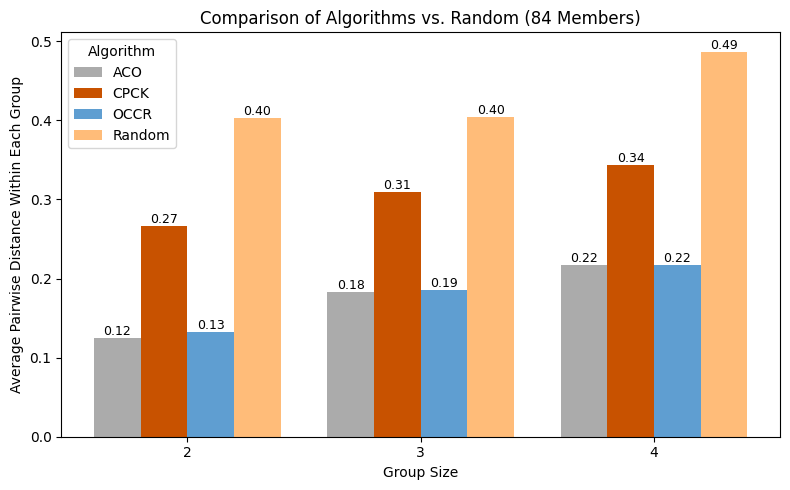

In [103]:
# Plot the results for the random comparison

pivot_df = results_84_random_vs_algos.pivot(index="group_size", columns="algorithm", values="average_distance")

bar_colors = ['#ABABAB', '#C85200','#5F9ED1' , '#FFBC79']  # List of colors for the bars

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.2
x = np.arange(len(pivot_df.index))  # x positions for group sizes

# Create bars for each algorithm and add values on top
for i, algorithm in enumerate(pivot_df.columns):
    bars = ax.bar(x + i * bar_width, pivot_df[algorithm], width=bar_width, label=algorithm, color=bar_colors[i % len(bar_colors)])
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x position
            height,  # y position
            f"{height:.2f}",  # text to display
            ha="center",  # horizontal alignment
            va="bottom",  # vertical alignment
            fontsize=9,  # font size
        )

# Set labels and ticks
ax.set_xlabel("Group Size")
ax.set_ylabel("Average Pairwise Distance Within Each Group")
ax.set_title("Comparison of Algorithms vs. Random (84 Members)")
ax.set_xticks(x + bar_width * (len(pivot_df.columns) - 1) / 2)
ax.set_xticklabels(pivot_df.index)
ax.legend(title="Algorithm")

# Show plot
plt.tight_layout()
plt.savefig(f"comparison_plots/random_comparison{group_size}.pdf")
